<div style="background-color: black; padding: 20px; border: 10px solid #c6b583; display: flex; align-items: center; justify-content: center; font-size: 50px;">
    <span style="color: white; font-weight: bold;">The Grammy </span>
    <img src="https://static.wikia.nocookie.net/sza/images/c/c2/Grammy_Awards.jpg/revision/latest?cb=20230507052140" alt="Logo Grammy" style="width: 100px; height: 90px; margin: 0 20px;">
    <span style="color: white;  font-weight: bold;">Awards </span>
</div>


Welcome to this Exploratory Data Analysis (EDA) notebook for Worshop-2! In this analysis, we will dive into a comprehensive exploration of the dataset. EDA is a crucial step in the data analysis process, allowing us to understand the structure of the data.

<h3 style="margin: 0; font-weight: bold;">Objectives</h3>


The primary objectives of this EDA are as follows:

1. **Understand the Data:** Get an overview of the dataset's structure, features, and general statistics.
2. **identify possible transformations and apply them:** Identify and handle missing values, or any inconsistencies in the data.
3. **Visualizations:** Create informative visualizations to better understand the data and convey insights.

---

<h3 style="margin: 0; font-weight: bold;">Beginning of Exploratory Data Analysis (EDA)</h3>

Set your work directory, be sure of have you own file (`.env`) with your environment variables, in this case 'WORK_DIR' 

In [1]:
import sys
import os

work_dir = os.getenv('WORK_DIR')

sys.path.append(work_dir)

Import the neccesary libreries and modules

In [2]:
from src.models.database_models import GrammyAwards
from src.database.db_connection import get_engine
from airflow.transfromations.transformations import Transformations
from airflow.transfromations.transformations import drop_null_values, clean_and_fill_artist, clean_and_fill_workers, drop_columns, rename_columns
from sqlalchemy import inspect
from sqlalchemy.orm import sessionmaker
import logging as log
import pandas as pd 
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import seaborn as sns

Applying the log method to INFO

In [3]:
log.basicConfig(level=log.INFO)

Connecting to a database are being performed using SQLAlchemy

In [4]:
connection = get_engine()
Session = sessionmaker(bind=connection)
session = Session()

INFO:root:Conected successfully to database PruebaCarga2!


Checking if a table named 'grammy_awards' exists in the database connected via the 'connection' object. If the table exists, it attempts to drop and recreate it, logging success or failure messages accordingly. If the table does not exist, it simply tries to create it and logs the outcome.

In [5]:
if inspect(connection).has_table('grammy_awards'):
    try:
        GrammyAwards.__table__.drop(connection)
        GrammyAwards.__table__.create(connection)
        log.info("Table created successfully.")
    except Exception as e:
        log.error(f"Error creating table: {e}")
else:
    try:
        GrammyAwards.__table__.create(connection)
        log.info("Table created successfully.")
    except Exception as e:
        log.error(f"Error creating table: {e}")

INFO:root:Table created successfully.


Performing initial data transformations on the grammy dataset stored in a CSV. Specifically, it inserts an ID column and converts the 'year' column to datetime format

In [6]:
try: 
    transformations = Transformations('../data/the_grammy_awards.csv')
    transformations.insert_id()
    transformations.convert_to_datetime('year')
    log.info("Data transformed successfully.")

except Exception as e:
    
    log.error(f"Error transforming data: {e}")

INFO:root:Data transformed successfully.


Inserting the transformed DataFrame `(transformations.df)` into a SQL database table named 'grammy_awards'

In [7]:
transformations.df.to_sql('grammy_awards', connection, if_exists='replace', index=False)
log.info("Data inserted successfully.")

INFO:root:Data inserted successfully.


Bringing our table 'grammy_awards' from our database models as pandas DataFrame

In [8]:
query = session.query(GrammyAwards).statement
df = pd.read_sql(query, connection)

This summary helps in understanding the size and structure of the dataset.

In [9]:
print(f"Number of Row : {df.shape[0]}\nNumber of Columns : {df.shape[1]}")
print('Structure of the raw DataFrame'.center(75, '-'))
df.head(5)

Number of Row : 4810
Number of Columns : 11
-----------------------Structure of the raw DataFrame----------------------


,id,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner
0,1,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",https://www.grammy.com/sites/com/files/styles/...,True
1,2,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",https://www.grammy.com/sites/com/files/styles/...,True
2,3,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",https://www.grammy.com/sites/com/files/styles/...,True
3,4,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",https://www.grammy.com/sites/com/files/styles/...,True
4,5,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",https://www.grammy.com/sites/com/files/styles/...,True


This summary provides a  overview of characteristics of the dataset, facilitating initial EDA and quality assessment.

- **Data Types:** Indicates the data type of each column in our DataFrame (`df`). (objects, ints and a boolean) 

- **Null Count:** Shows the number of null or missing values in each column. ~ This dataset contains many null values in the columns [`'artist', 'workers' and 'img'`]. A way must be found to impute this data so that all these records are not lost.

- **Unique Values:** Represents the count of unique values in each column. ~ In this case, it is normal that there are few non-unique values since in the context of the nominations, both the artist and the nominated album can be quite repeated. 

- **Duplicate Count:** Displays the number of duplicate rows in the DataFrame. ~ This dataset does not contain duplicate values

In [10]:
df_summary = pd.DataFrame({
    'dtypes': df.dtypes,
    'null count': df.isnull().sum(),
    'unique values': df.nunique(),
    'duplicate count': df.duplicated().sum(),
})

table = PrettyTable()
table.field_names = ["Column", "Data Type", "Null Count", "Unique Values", "Duplicate Count"]

for column in df_summary.index:
    data_type = df_summary.loc[column, 'dtypes']
    null_count = df_summary.loc[column, 'null count']
    unique_values = df_summary.loc[column, 'unique values']
    duplicate_count = df_summary.loc[column, 'duplicate count']
    table.add_row([column, data_type, null_count, unique_values, duplicate_count])

print(table)

+--------------+-----------+------------+---------------+-----------------+
|    Column    | Data Type | Null Count | Unique Values | Duplicate Count |
+--------------+-----------+------------+---------------+-----------------+
|      id      |   int64   |     0      |      4810     |        0        |
|     year     |   int64   |     0      |       62      |        0        |
|    title     |   object  |     0      |       62      |        0        |
| published_at |   object  |     0      |       4       |        0        |
|  updated_at  |   object  |     0      |       10      |        0        |
|   category   |   object  |     0      |      638      |        0        |
|   nominee    |   object  |     6      |      4131     |        0        |
|    artist    |   object  |    1840    |      1658     |        0        |
|   workers    |   object  |    2190    |      2366     |        0        |
|     img      |   object  |    1367    |      1463     |        0        |
|    winner 

Visualize the count of different data types (`dtypes`)

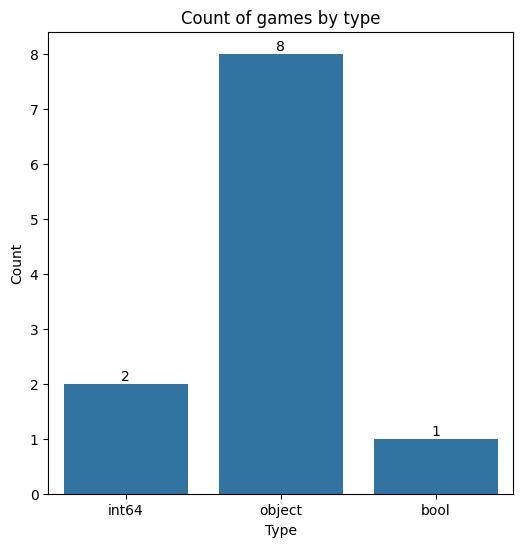

In [11]:
plt.figure(figsize=(6, 6))
ax = sns.countplot(x='dtypes', data=df_summary)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Count of games by type')
plt.xlabel('Type')
plt.ylabel('Count')

plt.show()

Here, we are doing a lot of things:

1. Defines a list of column names to be dropped (columns_drop) which includes 'published_at', 'updated_at', and 'img' ~ These columns will be deleted because they do not provide valuable information for our analysis. 

    - **'published_at' and 'updated_at':** These columns contain timing information related to the publication and updating of the data.The data is no longer relevant to the analysis, having these columns may take up unnecessary space and add complexity to the dataset without providing additional value.

    - **'img':** This column contains links to images associated with the data. Our the analysis is not focused on the content of the images additionally the column contains null values and removing them would cause information to be lost from the columns that do have information of interest to us.

2. Calls functions clean_and_fill_artist() and clean_and_fill_workers() to clean and fill missing values in the 'artist' and 'workers' columns of the DataFrame df.

In [12]:
colums_drop = ['published_at', 'updated_at', 'img']
drop_columns(df, colums_drop)

clean_and_fill_artist(df)
clean_and_fill_workers(df)

df.isnull().sum()

D:\Universidad/5to Semestre/ETL/Workshop-2\airflow\transfromations\transformations.py:74: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['extracted_nominee'] = pd.concat(extracted_nominees, axis=1).ffill(axis=1).iloc[:, -1]


id            0
year          0
title         0
category      0
nominee       6
artist      408
workers     186
winner        0
dtype: int64

The imputation of null values in the 'artist' and 'workers' columns was carried out to improve the completeness and usefulness of the data. After an initial review of the data set, these columns were identified as having a significant number of null values: 1840 for 'artist' going to only 480 null values and 2190 for 'workers' going to only 186 null values, significantly reducing the number of null values in these columns. 

Finally removing null values from the specified columns [`'nominee', 'workers', and 'artist'`] in the DataFrame, obtaining the entire dataset free of missing values 

In [13]:
remove_nulls = ['nominee', 'workers', 'artist']
drop_null_values(df, remove_nulls)

df.isnull().sum()

id          0
year        0
title       0
category    0
nominee     0
artist      0
workers     0
winner      0
dtype: int64

---
<h3 style="margin: 0; font-weight: bold;">Year</h3>



Looking the minimum and maximum year that the dataset have records 
It shows that the dataset starts from the year 1958 and ends at the year 2019 with a total of 62 year , spanning over several decades of Grammy history.

In [14]:
print('First year of the Grammy Awards: ', df['year'].min())
print('Last year of the Grammy Awards: ', df['year'].max())

First year of the Grammy Awards:  1958
Last year of the Grammy Awards:  2019


**Grammy Nominations by Decade**

Creates a visualization showing the number of Grammy nominations over different decades. We try to find out which years have more nominations, but there are so many years we decided to group them by decade.


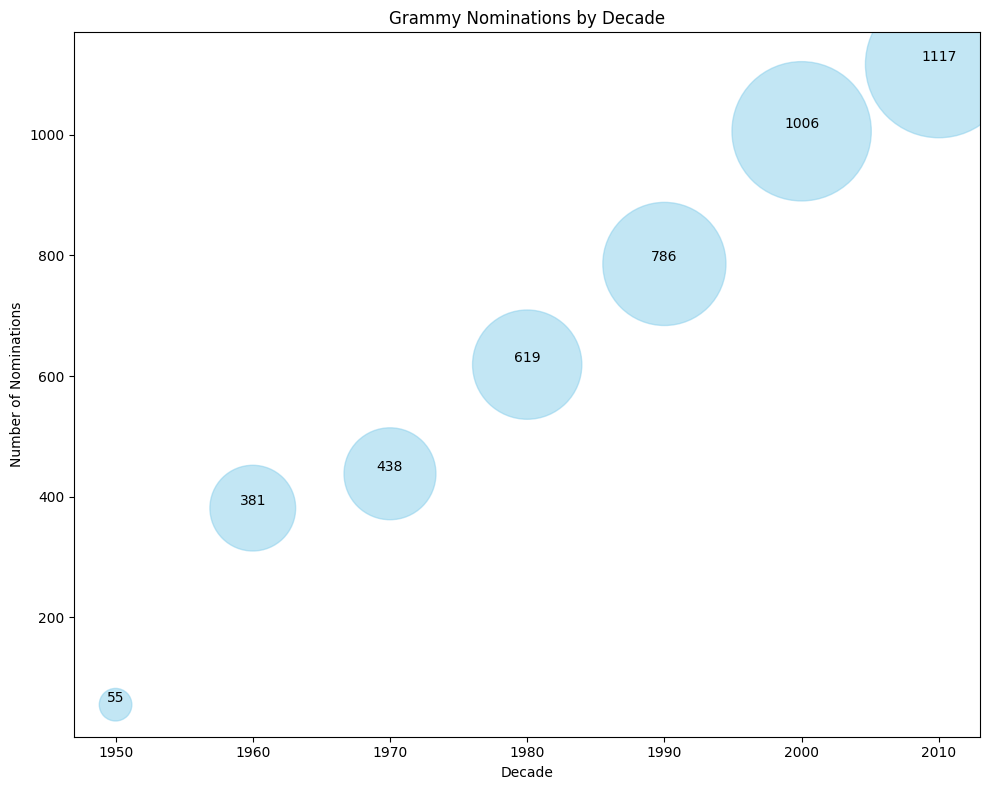

In [16]:
df['decade'] = (df['year'] // 10) * 10  
nominations_per_decade = df.groupby('decade').size()


sizes = nominations_per_decade.values * 10  

plt.figure(figsize=(10, 8))
plt.scatter(nominations_per_decade.index, nominations_per_decade.values, s=sizes, alpha=0.5, c='skyblue')

for decade, nominations in zip(nominations_per_decade.index, nominations_per_decade.values):
    plt.text(decade, nominations, str(nominations), ha='center', va='bottom', fontsize=10)

plt.title('Grammy Nominations by Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Nominations')
plt.grid(False)

plt.tight_layout()
plt.show()


Beginning with 55 nominations in the 1950s, the number steadily increases to peak in the 2010s with 1117 nominations. This suggests significant growth in the importance and diversity of music recognized by the Grammy Awards over time. The ascending trend may indicate an increase in artist participation, greater diversification of musical genres.

---

<marquee>
    <h3>Title</h3>
</marquee>

Taking a look into column Title

In [17]:
df['title'].unique()

array(['62nd Annual GRAMMY Awards  (2019)',
       '48th Annual GRAMMY Awards  (2005)',
       '46th Annual GRAMMY Awards  (2003)',
       '57th Annual GRAMMY Awards  (2014)',
       '61st Annual GRAMMY Awards  (2018)',
       '45th Annual GRAMMY Awards  (2002)',
       '60th Annual GRAMMY Awards  (2017)',
       '56th Annual GRAMMY Awards  (2013)',
       '59th Annual GRAMMY Awards  (2016)',
       '58th Annual GRAMMY Awards  (2015)',
       '55th Annual GRAMMY Awards  (2012)',
       '51st Annual GRAMMY Awards  (2008)',
       '50th Annual GRAMMY Awards  (2007)',
       '53rd Annual GRAMMY Awards  (2010)',
       '54th Annual GRAMMY Awards  (2011)',
       '52nd Annual GRAMMY Awards  (2009)',
       '39th Annual GRAMMY Awards  (1996)',
       '38th Annual GRAMMY Awards  (1995)',
       '49th Annual GRAMMY Awards  (2006)',
       '47th Annual GRAMMY Awards  (2004)',
       '27th Annual GRAMMY Awards  (1984)',
       '44th Annual GRAMMY Awards  (2001)',
       '43rd Annual GRAMMY Award

#### **Top 10 Titles with the Most Nominees**

This visualization helps to identify the titles that have received the highest number of nominations in the dataset.

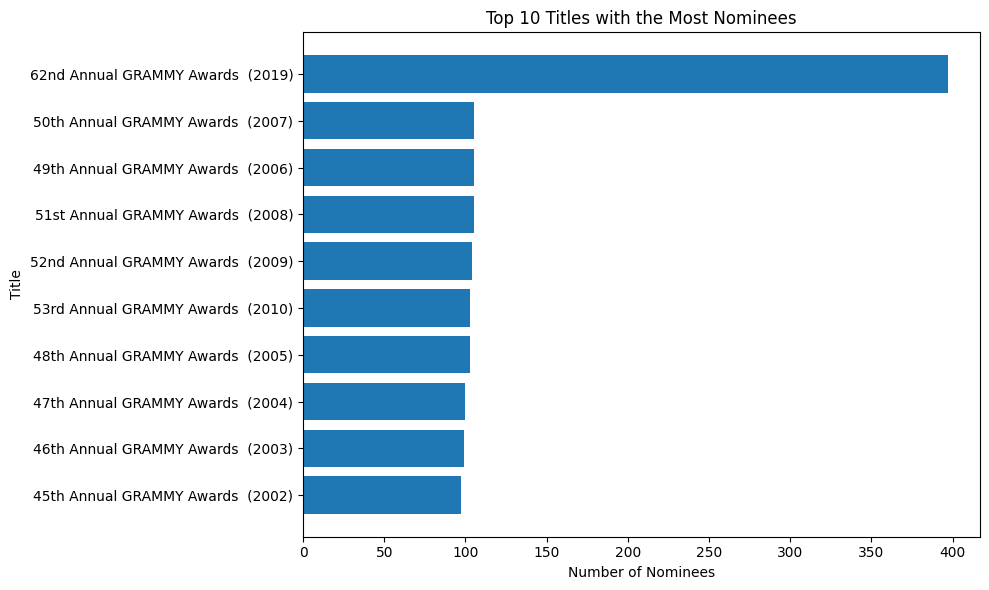

In [19]:
nominees_per_title = df['title'].value_counts().head(10)

top_10_titles = nominees_per_title.sort_values()

plt.figure(figsize=(10, 6))
plt.barh(top_10_titles.index, top_10_titles.values)

plt.xlabel('Number of Nominees')
plt.ylabel('Title')
plt.title('Top 10 Titles with the Most Nominees')

plt.tight_layout()
plt.show()

We can appreciate the anomaly in the number of nominees throughout the different years compared to 2019 at the Grammy Awards, in this year increased nominated artists? Let's find out what could be going on.

I will try to explain the possible reason for this anomaly with the artists that appear in the dataset nominated for best new artist, according to the dataset nominees for 2019.

<table>
    <tr>
        <th>Title</th>
        <th>Category</th>
        <th>Artist</th>
    </tr>
    <tr>
        <td>62nd Annual GRAMMY Awards (2019)</td>
        <td>Best New Artist</td>
        <td>Billie Eilish</td>
    </tr>
    <tr>
        <td>62nd Annual GRAMMY Awards (2019)</td>
        <td>Best New Artist</td>
        <td>Black Pumas</td>
    </tr>
    <tr>
        <td>62nd Annual GRAMMY Awards (2019)</td>
        <td>Best New Artist</td>
        <td>Lil Nas X</td>
    </tr>
    <tr>
        <td>62nd Annual GRAMMY Awards (2019)</td>
        <td>Best New Artist</td>
        <td>Lizzo</td>
    </tr>
    <tr>
        <td>62nd Annual GRAMMY Awards (2019)</td>
        <td>Best New Artist</td>
        <td>Maggie Rogers</td>
    </tr>
    <tr>
        <td>62nd Annual GRAMMY Awards (2019)</td>
        <td>Best New Artist</td>
        <td>ROSALÍA</td>
    </tr>
    <tr>
        <td>62nd Annual GRAMMY Awards (2019)</td>
        <td>Best New Artist</td>
        <td>Tank And The Bangas</td>
    </tr>
    <tr>
        <td>62nd Annual GRAMMY Awards (2019)</td>
        <td>Best New Artist</td>
        <td>Yola</td>
    </tr>
</table>

We can confirm this with the artists listed for 2018 in the dataset
In this case only 'Dua Lipa' appears in the dataset.

<table>
    <tr>
        <th>Title</th>
        <th>Category</th>
        <th>Artist</th>
    </tr>
    <tr>
        <td>61st Annual GRAMMY Awards (2018)</td>
        <td>Best New Artist</td>
        <td>Dua Lipa</td>
    </tr>
</table>

Confirming our theory, the internet lists Dua Lipa as a nominee for 2019 not 2018 as stated in the dataset, but looking for more context on the official Grammy website, this lack of consistency in dataset is explained by the institution itself. 

"The first thing you should know about the 2nd Annual GRAMMY Awards is that they weren’t actually “annual” at all. In fact, this awards presentation marked the only time in GRAMMY history that two awards presentations were ever made in one year, with both the 1st and 2nd GRAMMYs falling in 1959. Call it a slightly embarrassing case of premature validation."  

But other sources of information take it differently, in the context of the source of the information there is no date error.

---


<h3 style="margin: 0; font-weight: bold;">Category</h3>


Provides a brief glimpse into the unique values present in the "category" column

In [18]:
df['category'].unique()[:10]

array(['Record Of The Year', 'Album Of The Year',
       'Best Traditional Pop Vocal Album', 'Song Of The Year',
       'Best Pop Solo Performance', 'Best Pop Duo/Group Performance',
       'Best Contemporary Instrumental Album', 'Best Pop Vocal Album',
       'Best Dance Recording', 'Best Dance/Electronic Album'],
      dtype=object)

#### **Top 10 Most Repeated Categories at the Grammy Awards**
The plot provides a clear overview of the most common categories present in the Grammy Awards dataset, helping to identify the categories that have received the highest number of nominations or awards.

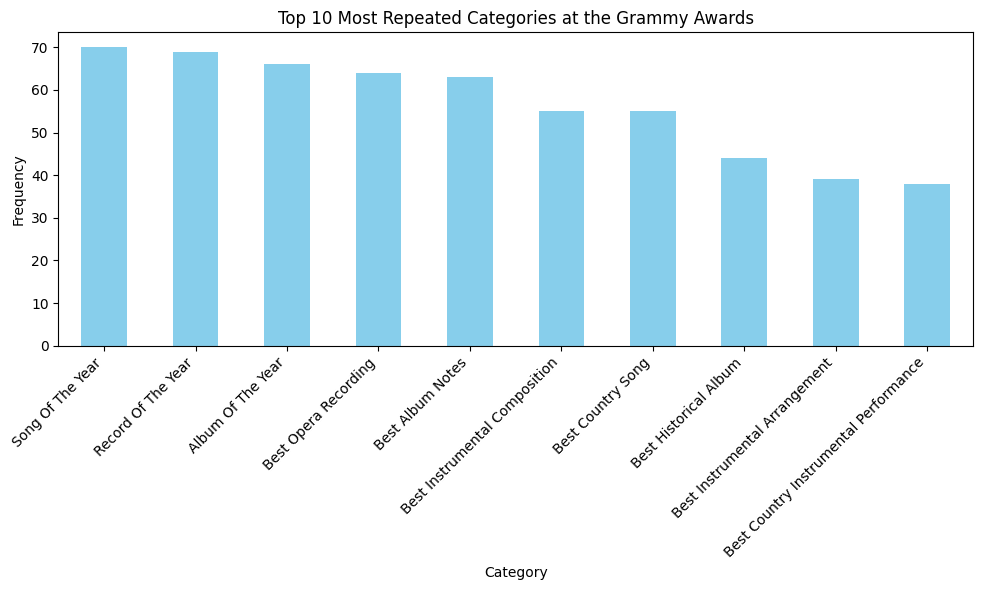

In [21]:
top_categories = df['category'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_categories.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Repeated Categories at the Grammy Awards')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(False)

plt.tight_layout()
plt.show()


It's evident that the categories with the highest frequency of occurrence in the Grammy Awards dataset are predominantly major award categories such as "Song Of The Year," "Record Of The Year," and "Album Of The Year."
These categories for artists should be the most important to aspire to because a single artist can win all 3 categories if is nominated. 

#### **Variation of Number of Categories per Year** 

It provides insights into how the diversity of award categories at the Grammy Awards has evolved over the years, highlighting any trends or fluctuations in the scope of recognition across different music genres and aspects.


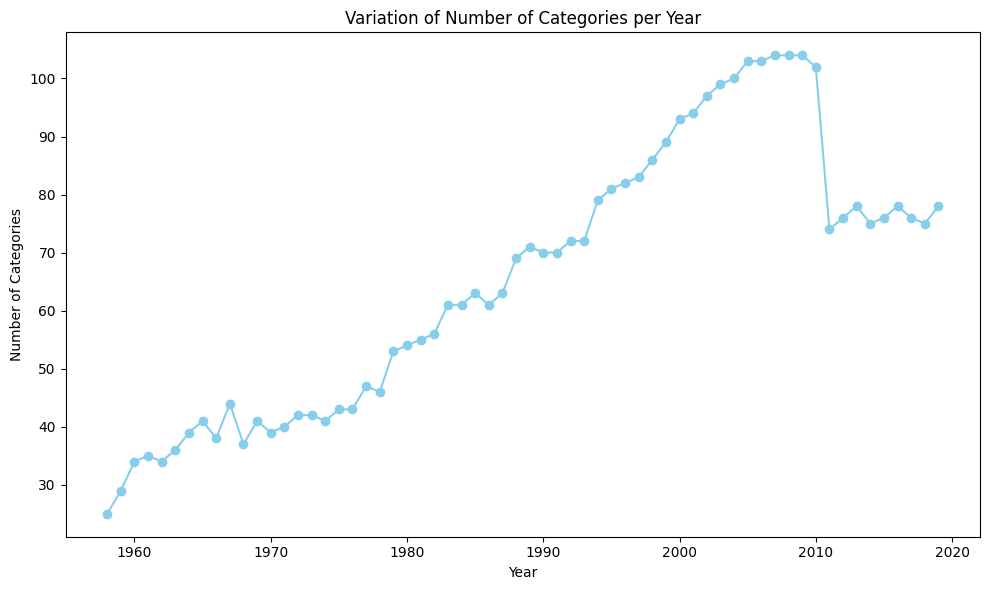

In [36]:
categories_per_year = df.groupby('year')['category'].nunique().reset_index()

categories_per_year.columns = ['Year', 'Number of Categories']

categories_per_year = categories_per_year.sort_values(by='Year')

plt.figure(figsize=(10, 6))
plt.plot(categories_per_year['Year'], categories_per_year['Number of Categories'], marker='o', color='skyblue', linestyle='-')

plt.title('Variation of Number of Categories per Year')
plt.xlabel('Year')
plt.ylabel('Number of Categories')
plt.grid(False)

plt.tight_layout()
plt.show()


We can observe several trends and fluctuations in the number of categories over the years:

1. Initial Increase: The number of categories steadily increases from the late 1950s to the late 1970s, with occasional fluctuations. This period sees a gradual expansion in the diversity of recognized categories.

2. Plateau and Growth: From the late 1970s to the early 1990s, there is a period of relative stability in the number of categories, with slight fluctuations. However, there's a noticeable increase in the early 1990s, indicating a renewed growth in the diversity of categories.

3. Rapid Growth: The 1990s witness a significant surge in the number of categories, especially towards the latter half of the decade. This period sees a substantial expansion in the scope of recognition across various music genres and aspects.

4. Peak and Stabilization: The early 2000s mark a peak in the number of categories, with counts reaching around 90 to over 100. However, after this peak, there's a stabilization and slight decline in the number of categories, suggesting a consolidation or refinement of award categories.

#### **Top 10 Artists Nominated to the Most Categories**  

Top 10 artists who have received nominations in the greatest variety of categories, along with the corresponding number of unique categories for each artist.

<Figure size 1000x600 with 0 Axes>

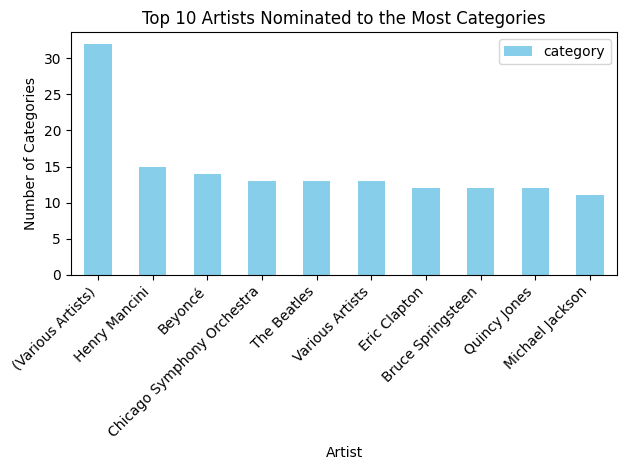

In [38]:
artist_categories = df.groupby('artist')['category'].nunique().reset_index()

artist_categories = artist_categories.sort_values(by='category', ascending=False)

plt.figure(figsize=(10, 6))
artist_categories.head(10).plot(kind='bar', x='artist', y='category', color='skyblue')
plt.title('Top 10 Artists Nominated to the Most Categories')
plt.xlabel('Artist')
plt.ylabel('Number of Categories')
plt.xticks(rotation=45, ha='right')
plt.grid(False)

plt.tight_layout()
plt.show()

The list is led by "Various Artists," with 32 unique categories, indicating a broad spectrum of musical contributions across different genres or compilations. It is closely followed by individual artists such as Henry Mancini, Beyoncé and The Beatles, each recognized in a significant number of different categories, demonstrating their versatility and impact in various facets of the music industry.

---

<h3 style="margin: 0; font-weight: bold;">Nominee</h3>

Albums Nominated to Most Categories
 
It provides insights into the nominees who have demonstrated versatility and recognition across various genres or music-related fields.



In [39]:
nominee_categories = df.groupby('nominee')['category'].nunique().reset_index()

nominee_categories = nominee_categories.sort_values(by='category', ascending=False)

print("Nominees Nominated to Most Categories:")
print(nominee_categories.head(10))  


Nominees Nominated to Most Categories:
                         nominee  category
595   Bridge Over Troubled Water         7
3557             Up, Up And Away         6
451             Berlioz: Requiem         5
1766            King Of The Road         5
1228           Gentle On My Mind         5
503                    Blackstar         5
3660             West Side Story         5
100             A Taste Of Honey         5
2230                Need You Now         5
2157                  Moon River         4


For example, "Bridge Over Troubled Water" has been nominated in seven distinct categories, implying its widespread recognition and versatility across different aspects of music. Similarly, other nominees like "Up, Up And Away," "Berlioz: Requiem," and "King Of The Road" have received nominations in six, five, and five categories, respectively. 

---

<h3 style="margin: 0; font-weight: bold;">Artist</h3>

Provide information on artists who have had a significant impact on the music industry and have been repeatedly recognized over the years for their work. 

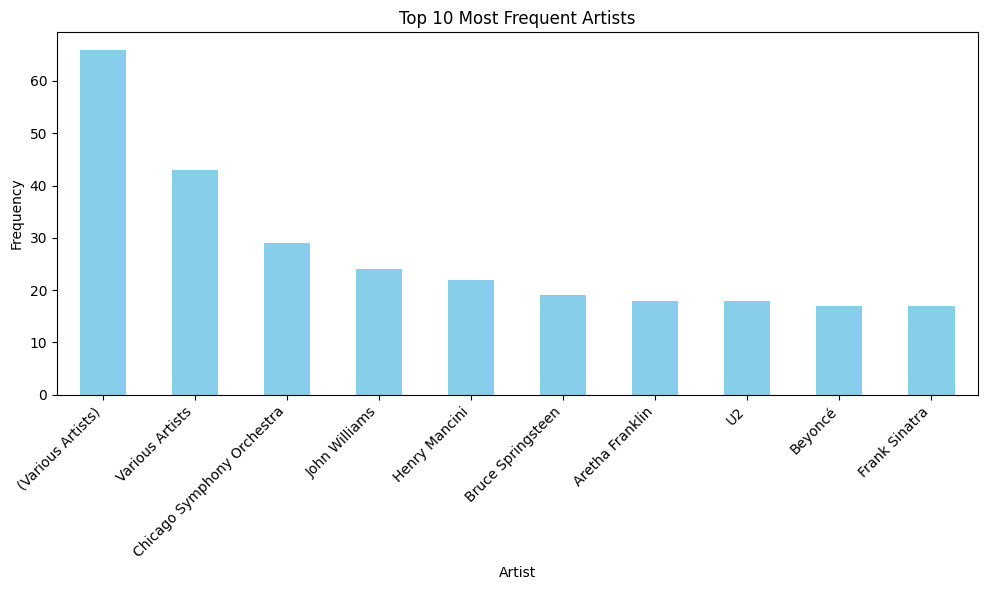

artist
(Various Artists)             66
Various Artists               43
Chicago Symphony Orchestra    29
John Williams                 24
Henry Mancini                 22
Bruce Springsteen             19
Aretha Franklin               18
U2                            18
Beyoncé                       17
Frank Sinatra                 17
Name: count, dtype: int64


In [41]:
artist_counts = df['artist'].value_counts().head(10)  
plt.figure(figsize=(10, 6))
artist_counts.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Frequent Artists')
plt.xlabel('Artist')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(False)
plt.tight_layout()
plt.show()

print(artist_counts)


"(Various Artists)" and "Various Artists" appear as separate entries, possibly due to different formatting or naming conventions in the dataset. The Chicago Symphony Orchestra, John Williams, and Henry Mancini are prominent in Grammy nominations, suggesting their significant contributions to music across various categories. Bruce Springsteen, Aretha Franklin, and U2 also feature prominently, reflecting their enduring influence and recognition in the industry. Beyoncé and Frank Sinatra round out the list, highlighting their consistent presence and impact on Grammy nominations over time.

#### **Most Nominated Artist per Decade**

It aims to identify the most nominated artist per decade based on Grammy nominations.

In [24]:
artist_nominations_per_decade = df.groupby(['decade', 'artist']).size()

most_nominated_artists_per_decade = artist_nominations_per_decade.groupby(level=0).idxmax()

print(f"Most Nominated Artist per Decade:\n {most_nominated_artists_per_decade}")


Most Nominated Artist per Decade:
 decade
1950      (1950, Ella Fitzgerald)
1960        (1960, Henry Mancini)
1970        (1970, Stevie Wonder)
1980      (1980, Michael Jackson)
1990    (1990, (Various Artists))
2000    (2000, (Various Artists))
2010    (2010, (Various Artists))
dtype: object


It indicates that Ella Fitzgerald was the most nominated artist in the 1950s, followed by Henry Mancini in the 1960s, Stevie Wonder in the 1970s, Michael Jackson in the 1980s, and Various Artists collectively in the 1990s, 2000s, and 2010s. This suggests a diverse range of influential artists dominating different eras of the Grammy Awards.

---

<h3 style="margin: 0; font-weight: bold;">Workers</h3>

We will use information identified in the contents of this column, some of which are identified patterns, as well as roles that were identified from the contents of this column.

#### **Bubble Chart of Role Frequencies**

Visualization is beneficial for understanding the distribution of roles in the context of the music industry and can help in the planning and allocation of resources for future projects.

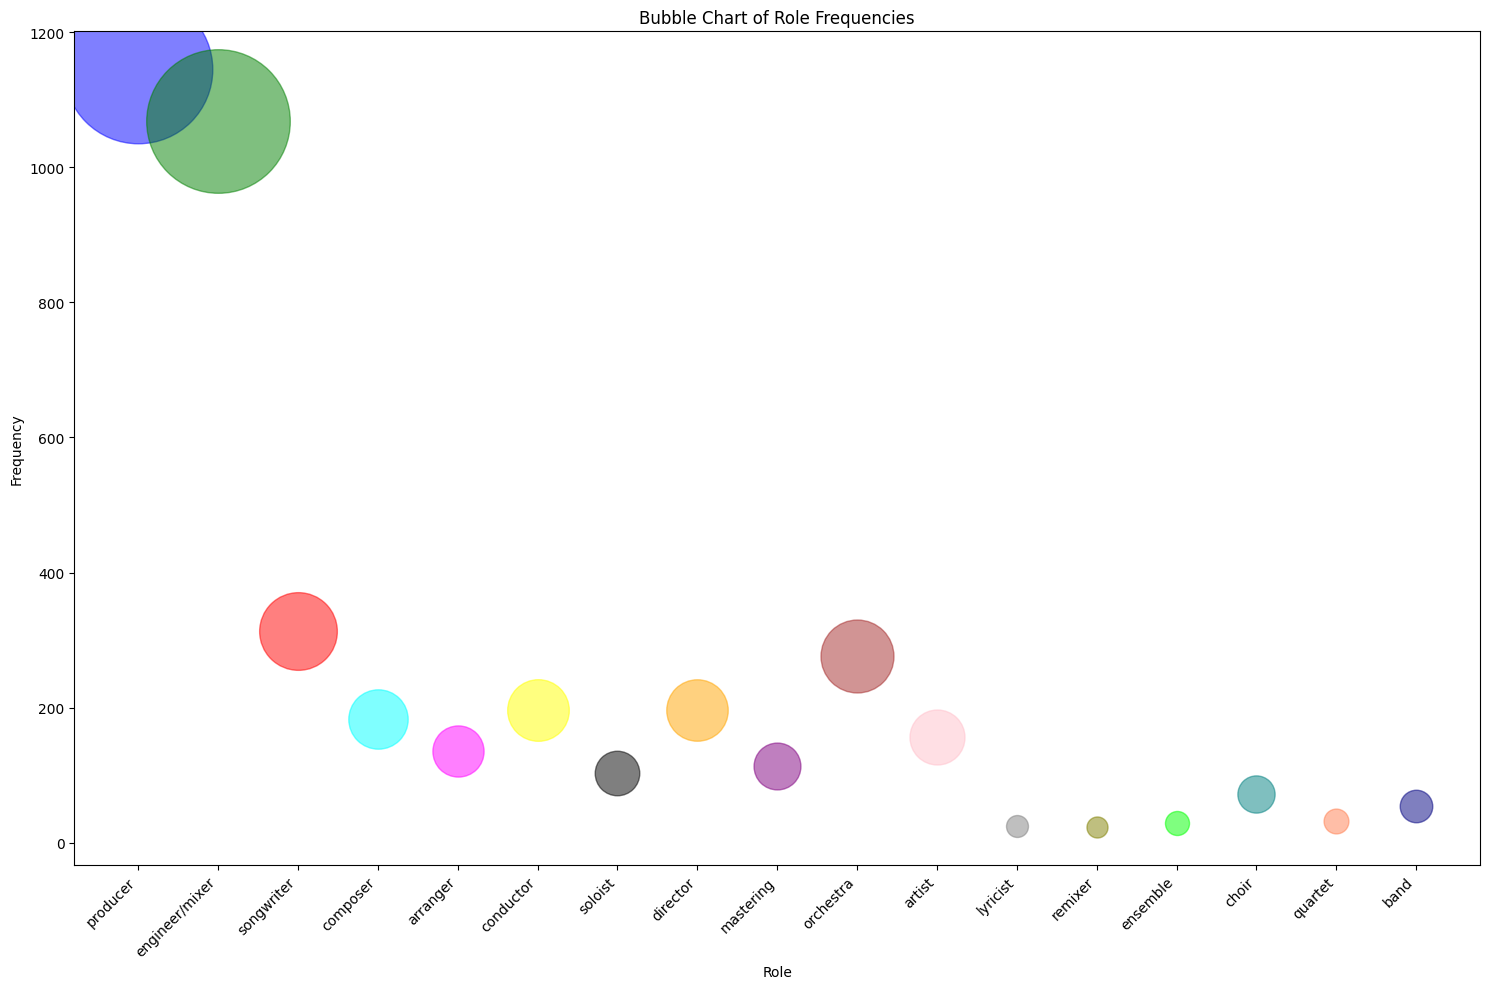

In [43]:
roles_dict = {
    'producer': ['producer', 'producers'],
    'engineer/mixer': ['engineer/mixer', 'engineers/mixers', 'engineer', 'engineers'],
    'songwriter': ['songwriter', 'songwriters'],
    'composer': ['composer'],
    'arranger': ['arranger', 'arrangers'],
    'conductor': ['conductor', 'conductors'],
    'soloist': ['soloist', 'soloists'],
    'director': ['director', 'directors'],
    'mastering': ['mastering'],
    'orchestra': ['orchestra', 'orchestras'],
    'artist': ['artist', 'artists'],
    'lyricist': ['lyricist', 'lyricists'],
    'remixer': ['remixer', 'remixers'],
    'ensemble': ['ensemble', 'ensembles'],
    'choir': ['choir', 'choirs'],
    'quartet': ['quartet', 'quartets'],
    'band': ['band', 'bands']
}

def count_roles(text):
    role_counts = {role: 0 for role in roles_dict}
    for word in text.split():
        for role, keywords in roles_dict.items():
            if any(keyword.lower() in word.lower() for keyword in keywords):
                role_counts[role] += 1
    return role_counts

role_counts_df = df['workers'].apply(count_roles).apply(pd.Series).fillna(0)

total_counts = role_counts_df.sum()

total_df = pd.DataFrame({'Role': total_counts.index, 'Count': total_counts.values})

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown',
          'pink', 'gray', 'olive', 'lime', 'teal', 'coral', 'navy', 'indigo']


plt.figure(figsize=(15, 10)) 
for role, color in zip(total_df['Role'], colors):
    count = total_df.loc[total_df['Role'] == role, 'Count'].values[0]
    plt.scatter(role, count, s=count*10, alpha=0.5, c=color, label=role)
plt.title('Bubble Chart of Role Frequencies')
plt.xlabel('Role')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(False)
plt.tight_layout()
plt.show()


From the analysis, it's evident that roles like "producer" and "engineer/mixer" are the most common, with counts of 1145 and 1069, respectively. This suggests that these roles are crucial in the production process and are likely to be found in a wide range of music projects. Other roles like "songwriter," "composer," and "arranger" also have significant representation, albeit less frequent than the top two roles. Roles such as "remixer" and "ensemble" appear to be less common based on their lower counts.

---

<h3 style="margin: 0; font-weight: bold;">Winner</h3>

Visualize the distribution of winners and losers in a dataset using a pie chart.


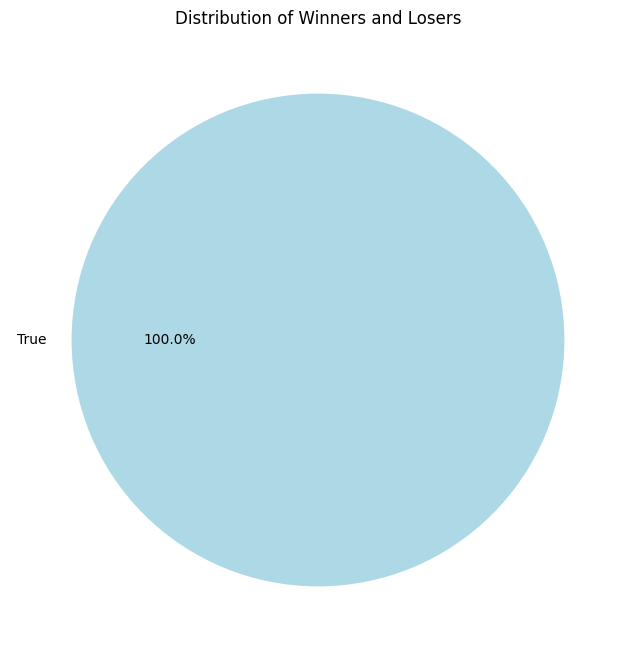

In [45]:
winner_counts = df['winner'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(winner_counts, labels=winner_counts.index, autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Distribution of Winners and Losers')
plt.show()


The absence of a count for losers implies that either there are no losers in the dataset or they are not explicitly labeled as such. 

At first you might think that according to this everyone is a winner, but for example there are several artists nominated in the same category so there can't be more than one winner. Another approach is to rename the winner column to "nominee_status" to give as an interpretation if the artist received a nomination or not, this will be useful for the merge with the Spotify dataset.

In [28]:
rename_columns(df, {'winner': 'nominee_status'})